# Google Colab

In [70]:
Google_Colab = True

In [71]:
import os

if Google_Colab:
  from google.colab import drive
  drive.mount('/content/gdrive')
  os.chdir("/content/gdrive/My Drive/FPL_ML")
else:
  os.chdir("D:\PulpitE\FPL_ML")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports

In [72]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [73]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - number of gameweeks required
FFP = 15

NEXT_GAMEWEEK = 19

In [74]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Device

In [75]:
device = torch.device("cuda")
# device = torch.device('mps')
# device = torch.device('cpu')

# Getting data and choosing features

In [76]:
df = pd.read_csv('data/final_dataset.csv')

In [77]:
# remembering original df
df_original = df

In [78]:
df_original.iloc[0]

Unnamed: 0                          0
Date                       2022-08-06
Day                               Sat
Comp                   Premier League
Round                     Matchweek 1
Venue                            Home
Squad                    Leeds United
Opponent                       Wolves
Start                               Y
Pos                                RW
Min                              83.0
Gls                               0.0
Ast                               0.0
PK                                0.0
PKatt                             0.0
Sh                                1.0
SoT                               0.0
CrdY                              0.0
CrdR                              0.0
Touches                          36.0
Tkl                               2.0
Int                               0.0
Blocks                            2.0
xG                                0.0
npxG                              0.0
xAG                               0.0
SCA         

In [79]:
info = ["Name", "GW", "FPL position"]
other = ["LSTM"]
features = ["Min", "Gls", "Ast", "Sh", "SoT", "xG", "npxG", "xAG", "SCA", "GCA", "CS", "CrdY", "CrdR", "Opp rating", "Team Score", "Opp Score", "Was Home"]
to_predict = ["FPL"]

In [80]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [81]:
df.shape

(7457, 21)

In [82]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking onyl players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [83]:
df.shape

(5771, 21)

In [84]:
df.head(20)

,Name,GW,FPL position,Min,Gls,Ast,Sh,SoT,xG,npxG,...,SCA,GCA,CS,CrdY,CrdR,Opp rating,Team Score,Opp Score,Was Home,FPL
0,Brenden-Aaronson,1,MID,83.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1725.276489,2.0,1.0,1.0,2.0
1,Brenden-Aaronson,2,MID,90.0,0.0,0.0,2.0,0.0,0.1,0.1,...,4.0,0.0,0.0,1.0,0.0,1667.049927,2.0,2.0,0.0,2.0
2,Brenden-Aaronson,3,MID,82.0,1.0,0.0,2.0,2.0,1.0,1.0,...,5.0,1.0,1.0,0.0,0.0,1901.388306,3.0,0.0,1.0,8.0
3,Brenden-Aaronson,4,MID,81.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,1.0,0.0,1783.540161,0.0,1.0,0.0,2.0
4,Brenden-Aaronson,5,MID,75.0,0.0,1.0,1.0,1.0,0.1,0.1,...,4.0,1.0,0.0,0.0,0.0,1688.922485,1.0,1.0,1.0,5.0
5,Brenden-Aaronson,6,MID,90.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1727.113647,2.0,5.0,0.0,2.0
6,Brenden-Aaronson,9,MID,78.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,0.0,0.0,1716.016846,0.0,0.0,1.0,3.0
7,Brenden-Aaronson,10,MID,75.0,0.0,0.0,2.0,0.0,0.1,0.1,...,3.0,1.0,0.0,0.0,0.0,1748.905396,1.0,2.0,0.0,2.0
8,Brenden-Aaronson,11,MID,90.0,0.0,0.0,2.0,1.0,0.1,0.1,...,4.0,0.0,0.0,0.0,0.0,1908.041016,0.0,1.0,1.0,2.0
9,Brenden-Aaronson,12,MID,90.0,0.0,0.0,1.0,0.0,0.1,0.1,...,3.0,0.0,0.0,0.0,0.0,1730.854736,0.0,2.0,0.0,2.0


In [85]:
last_names = df["Name"].unique()

In [86]:
df.columns

Index(['Name', 'GW', 'FPL position', 'Min', 'Gls', 'Ast', 'Sh', 'SoT', 'xG',
       'npxG', 'xAG', 'SCA', 'GCA', 'CS', 'CrdY', 'CrdR', 'Opp rating',
       'Team Score', 'Opp Score', 'Was Home', 'FPL'],
      dtype='object')

In [87]:
df["FPL position"].unique()

array(['MID', 'FWD', 'DEF', 'GK'], dtype=object)

# DF to DataLoader

In [88]:
# gk, def, mid, fwd
df_gk = df[df["FPL position"] == "GK"]
df_def = df[df["FPL position"] == "DEF"]
df_mid = df[df["FPL position"] == "MID"]
df_fwd = df[df["FPL position"] == "FWD"]

In [89]:
df.shape

(5771, 21)

In [90]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [91]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.index_table = init_index_table(dataframe)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        length = 0
        for name in self.names:
            length += (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS)
        return length

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = self.index_table[idx]
        name = self.names[player_id]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [92]:
# df[["Name", "FPL position"]].drop_duplicates().head(20)

In [93]:
dataset = PandasDataset(df)
dataset_gk = PandasDataset(df_gk)
dataset_def = PandasDataset(df_def)
dataset_mid = PandasDataset(df_mid)
dataset_fwd = PandasDataset(df_fwd)

In [94]:
dataset.__getitem__(0)

(array([[8.3000000e+01, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.7252765e+03, 2.0000000e+00, 1.0000000e+00,
         1.0000000e+00],
        [9.0000000e+01, 0.0000000e+00, 0.0000000e+00, 2.0000000e+00,
         0.0000000e+00, 1.0000000e-01, 1.0000000e-01, 1.0000000e-01,
         4.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
         0.0000000e+00, 1.6670499e+03, 2.0000000e+00, 2.0000000e+00,
         0.0000000e+00],
        [8.2000000e+01, 1.0000000e+00, 0.0000000e+00, 2.0000000e+00,
         2.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e-01,
         5.0000000e+00, 1.0000000e+00, 1.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.9013883e+03, 3.0000000e+00, 0.0000000e+00,
         1.0000000e+00],
        [8.1000000e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.00

In [95]:
dataset_fwd.__getitem__(10)

(array([[9.0000000e+01, 1.0000000e+00, 0.0000000e+00, 2.0000000e+00,
         1.0000000e+00, 4.0000001e-01, 4.0000001e-01, 0.0000000e+00,
         1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.6624321e+03, 1.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [1.8000000e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.9162506e+03, 1.0000000e+00, 1.0000000e+00,
         1.0000000e+00],
        [9.0000000e+01, 0.0000000e+00, 0.0000000e+00, 5.0000000e+00,
         2.0000000e+00, 6.9999999e-01, 6.9999999e-01, 1.0000000e-01,
         6.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.7513988e+03, 0.0000000e+00, 1.0000000e+00,
         0.0000000e+00],
        [6.3000000e+01, 0.0000000e+00, 0.0000000e+00, 2.0000000e+00,
         0.0000000e+00, 2.00

In [96]:
dataset_gk.__len__()

305

In [97]:
dataset_def.__len__()

1137

In [98]:
dataset_mid.__len__()

1469

In [99]:
dataset_fwd.__len__()

356

In [100]:
batch_size = 16

In [101]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
dataloader_gk = DataLoader(dataset_gk, batch_size=batch_size, shuffle=False)
dataloader_def = DataLoader(dataset_def, batch_size=batch_size, shuffle=False)
dataloader_mid = DataLoader(dataset_mid, batch_size=batch_size, shuffle=False)
dataloader_fwd = DataLoader(dataset_fwd, batch_size=batch_size, shuffle=False)

In [102]:
# next(iter(dataloader_mid))

In [103]:
# next(iter(dataloader))[1]

# LSTM Model

In [104]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

In [105]:
len(dataloader)

205

# Training loops

In [106]:
criterion = nn.MSELoss()

In [107]:
def train_net(net, num_epochs, dataloader, optimizer):
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = torch.flatten(inputs, 1, 2)
            inputs = inputs.unsqueeze(2).to(device)
            targets = targets.to(device)
            # print("INPUTS", inputs.shape)
            # print("TARGETS", targets.shape)
            # print(targets)
            optimizer.zero_grad()
            outputs = net(inputs).flatten().to(device)
            # print("OUTPUTS", outputs.shape)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        loss_history.append(running_loss / len(dataloader))
        if epoch % 5 == 0:
            print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')
    
    return loss_history

In [108]:
def plot_loss_history(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## Training loop - general net

In [109]:
%%time
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_history = train_net(net, 30, dataloader, optimizer)

Epoch 0 Loss: 3.8219702576718677
Epoch 5 Loss: 3.4718593077688684
Epoch 10 Loss: 3.0795653294499328
Epoch 15 Loss: 3.09020839500718
Epoch 20 Loss: 3.033646007863487
Epoch 25 Loss: 3.055859406837603
CPU times: user 3min 35s, sys: 2.13 s, total: 3min 37s
Wall time: 3min 37s


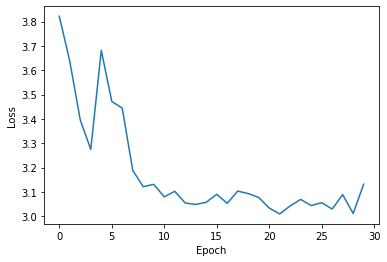

In [110]:
plot_loss_history(loss_history)

## Training loop - goalkeeper net

In [111]:
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [112]:
%%time
optimizer_gk = optim.Adam(net_gk.parameters(), lr=0.01)
loss_history_gk = train_net(net_gk, 50, dataloader_gk, optimizer_gk)

Epoch 0 Loss: 1.4476423459127545
Epoch 5 Loss: 0.5034158806316554
Epoch 10 Loss: 0.5038231655955314
Epoch 15 Loss: 0.5001771382987499
Epoch 20 Loss: 0.49920430248603226
Epoch 25 Loss: 0.4987034362740815
Epoch 30 Loss: 0.49944283068180084
Epoch 35 Loss: 0.49996499381959436
Epoch 40 Loss: 0.5003919153474271
Epoch 45 Loss: 0.4985835093073547
CPU times: user 22.9 s, sys: 235 ms, total: 23.2 s
Wall time: 23.1 s


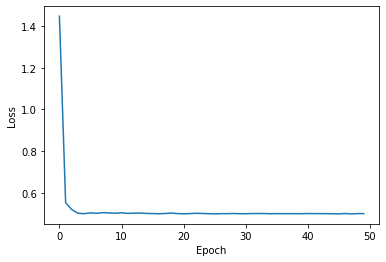

In [113]:
plot_loss_history(loss_history_gk)

## Training loop - defender net

In [114]:
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [115]:
%%time
optimizer_def = optim.Adam(net_def.parameters(), lr=0.005)
loss_history_def = train_net(net_def, 50, dataloader_def, optimizer_def)

Epoch 0 Loss: 1.696814784159263
Epoch 5 Loss: 1.2569491902573242
Epoch 10 Loss: 1.2536016862011619
Epoch 15 Loss: 1.252280994421906
Epoch 20 Loss: 1.2512522836526234
Epoch 25 Loss: 1.2495777969145112
Epoch 30 Loss: 1.2510743610974815
Epoch 35 Loss: 1.25068816025224
Epoch 40 Loss: 1.2511507434149582
Epoch 45 Loss: 1.2506959858453937
CPU times: user 1min 37s, sys: 855 ms, total: 1min 38s
Wall time: 1min 37s


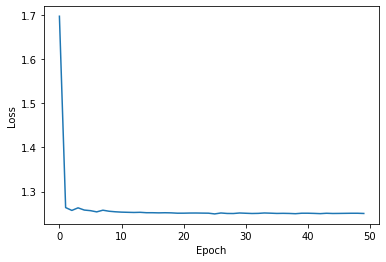

In [116]:
plot_loss_history(loss_history_def)

## Training loop - midfielder net

In [117]:
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [118]:
%%time
optimizer_mid = optim.Adam(net_mid.parameters(), lr=0.005)
loss_history_mid = train_net(net_mid, 50, dataloader_mid, optimizer_mid)

Epoch 0 Loss: 5.245470082630282
Epoch 5 Loss: 4.721383534047915
Epoch 10 Loss: 4.71558418351671
Epoch 15 Loss: 4.728342440465222
Epoch 20 Loss: 4.728956550359726
Epoch 25 Loss: 4.727977408663087
Epoch 30 Loss: 4.728496669427209
Epoch 35 Loss: 4.728728236711544
Epoch 40 Loss: 4.7270859026390575
Epoch 45 Loss: 4.727594199387924
CPU times: user 2min 10s, sys: 1.29 s, total: 2min 12s
Wall time: 2min 11s


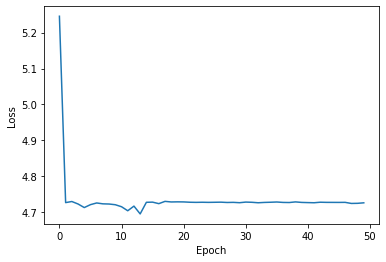

In [119]:
plot_loss_history(loss_history_mid)

## Training loop - forward net

In [120]:
net_fwd = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [121]:
%%time
optimizer_fwd = optim.Adam(net_fwd.parameters(), lr=0.005)
loss_history_fwd = train_net(net_fwd, 100, dataloader_fwd, optimizer_fwd)

Epoch 0 Loss: 11.871081915886506
Epoch 5 Loss: 8.340499338896379
Epoch 10 Loss: 8.337865596232207
Epoch 15 Loss: 8.31169675225797
Epoch 20 Loss: 8.367100565329842
Epoch 25 Loss: 8.340113388455432
Epoch 30 Loss: 8.342138528823853
Epoch 35 Loss: 8.326797506083613
Epoch 40 Loss: 8.313344978767892
Epoch 45 Loss: 8.325807882391889
Epoch 50 Loss: 8.350577287051989
Epoch 55 Loss: 8.28042566517125
Epoch 60 Loss: 8.304268536360368
Epoch 65 Loss: 8.178259336430093
Epoch 70 Loss: 8.146291538425114
Epoch 75 Loss: 8.266287503035173
Epoch 80 Loss: 7.980785800063091
Epoch 85 Loss: 7.863771607046542
Epoch 90 Loss: 7.229605499816977
Epoch 95 Loss: 7.619630509096643
CPU times: user 53.9 s, sys: 526 ms, total: 54.4 s
Wall time: 54.2 s


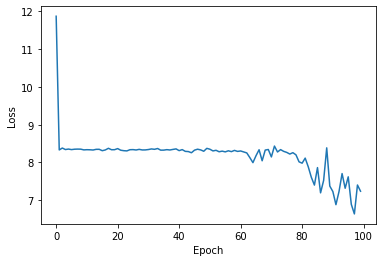

In [122]:
plot_loss_history(loss_history_fwd)

# Saving models to files

In [123]:
torch.save(net.state_dict(), 'models/lstm_general.pt')

torch.save(net_gk.state_dict(), 'models/lstm_gk.pt')
torch.save(net_def.state_dict(), 'models/lstm_def.pt')
torch.save(net_mid.state_dict(), 'models/lstm_mid.pt')
torch.save(net_fwd.state_dict(), 'models/lstm_fwd.pt')

# Predictions - general model

In [124]:
def generate_predictions(dataloader_pos, dataset_pos, net_pos):
    index = 0
    predictions_pos = []
    for inputs, target in dataloader_pos:
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2).to(device)
        # print("INPUTS", inputs)
        # print(inputs)
        outputs = net_pos(inputs).to(device)
        # print("OUTPUTS", outputs)
        for output in outputs:
            player_id, sample_id = dataset_pos.index_table[index]
            name = dataset_pos.names[player_id]
            points = round(output.item(), 2)
            gw = sample_id + FIS + 1
            predictions_pos.append([name, gw, points])
            # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
            index += 1
    
    return predictions_pos

In [125]:
predictions = generate_predictions(dataloader, dataset, net)

In [126]:
# results sorted
pd.DataFrame(predictions, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
724,Kevin-De-Bruyne,10,5.17
1552,Harry-Kane,15,5.16
3218,Wilfried-Zaha,10,5.16
2568,Mohamed-Salah,15,5.16
1029,Bruno-Fernandes,18,5.16
2912,Ivan-Toney,11,5.16
1887,Martinelli,13,5.16
2917,Ivan-Toney,16,5.16
1381,Son-Heung-min,9,5.16
731,Kevin-De-Bruyne,17,5.16


In [127]:
# appending results to original df
for name, gw, points in predictions:
    df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [128]:
df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

# Predictions for each position

## Goalkeepers

In [129]:
predictions_gk = generate_predictions(dataloader_gk, dataset_gk, net_gk)

In [130]:
# results sorted
pd.DataFrame(predictions_gk, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
121,Dean-Henderson,13,2.17
61,Ederson,14,2.17
291,Mark-Travers,19,2.16
206,Jordan-Pickford,16,2.16
265,Jose-Sa,16,2.16
170,Emiliano-Martinez,14,2.16
276,Robert-Sanchez,15,2.16
91,Fraser-Forster,20,2.15
199,Jordan-Pickford,9,2.15
203,Jordan-Pickford,13,2.15


## Defenders

In [131]:
predictions_def = generate_predictions(dataloader_def, dataset_def, net_def)

In [132]:
# results sorted
pd.DataFrame(predictions_def, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
0,Tosin-Adarabioyo,9,2.24
1029,Joel-Veltman,11,2.24
1028,Joel-Veltman,10,2.24
676,Tyrick-Mitchell,15,2.24
496,Max-Kilman,17,2.24
895,Jack-Stacey,11,2.24
1021,Raphael-Varane,12,2.24
393,Pervis-Estupinan,15,2.24
1017,Virgil-van-Dijk,17,2.24
1016,Virgil-van-Dijk,16,2.24


## Midfielders

In [133]:
predictions_mid = generate_predictions(dataloader_mid, dataset_mid, net_mid)

In [134]:
# results sorted
pd.DataFrame(predictions_mid, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
746,Mathias-Jensen,19,3.02
136,Rodrigo-Bentancur,15,3.01
722,Daniel-James,18,3.01
137,Rodrigo-Bentancur,16,3.01
177,Bryan,13,3.01
1098,Cole-Palmer,11,3.01
640,Luke-Harris,17,3.01
646,Jack-Harrison,14,3.01
15,Tyler-Adams,13,3.01
560,Morgan-Gibbs-White,17,3.00


## Forwards

In [135]:
predictions_fwd = generate_predictions(dataloader_fwd, dataset_fwd, net_fwd)

In [136]:
# results sorted
pd.DataFrame(predictions_fwd, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
106,Erling-Haaland,9,5.81
109,Erling-Haaland,12,5.79
223,Aleksandar-Mitrovic,11,5.75
226,Aleksandar-Mitrovic,14,5.72
224,Aleksandar-Mitrovic,12,5.67
337,Callum-Wilson,9,5.64
110,Erling-Haaland,13,5.60
221,Aleksandar-Mitrovic,9,5.57
116,Erling-Haaland,19,5.50
170,Harry-Kane,14,5.48
